In [1]:
import yaml
from tqdm import tqdm
from src.utils import get_dataset
from torch.utils.data import DataLoader

from torchvision import transforms
from diffusers import UNet2DModel
from PIL import Image
from diffusers import DDPMScheduler
import torch
import torch.nn.functional as F
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path

/home/neelesh/anaconda3/envs/crackseg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('experiments/crack500_2/ddpm.yaml') as f:
    config = yaml.safe_load(f)

# print(config['dim'])
dataset = get_dataset(config['training_path'], config['dim'][0], config['num_training_images'], config['model_type'])
image_dataloader = DataLoader(dataset, batch_size=config['train_batch_size'], shuffle=True)

Take first 500 images...


In [3]:
model = UNet2DModel(
    sample_size=config['dim'][0],  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [4]:
sample_image = 2.0 * dataset[0][1].unsqueeze(0).unsqueeze(0) - 1.0
# sample_label = dataset[0][1].unsqueeze(0)
print("Input shape:", sample_image.shape)
# print("Label : ", sample_label.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


In [5]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
# print(noisy_image.shape)

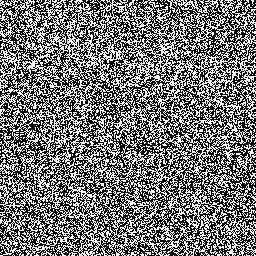

In [6]:
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).squeeze(-1).type(torch.uint8).numpy()[0])

In [7]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"])
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config["lr_warmup_steps"],
    num_training_steps=(len(image_dataloader) * config["num_epochs"]),
)

In [9]:
def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config["eval_batch_size"],
        generator=torch.manual_seed(config["seed"]),
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config["output_dir"], "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [10]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config["mixed_precision"],
        gradient_accumulation_steps=config["gradient_accumulation_steps"],
        log_with="tensorboard",
        project_dir=os.path.join(config["output_dir"], "logs"),
    )
    if accelerator.is_main_process:
        if config["output_dir"] is not None:
            os.makedirs(config["output_dir"], exist_ok=True)
        # if config["push_to_hub"]:
        #     repo_id = create_repo(
        #         repo_id=config["hub_model_id"] or Path(config["output_dir"]).name, exist_ok=True
        #     ).repo_id
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config["num_epochs"]):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, (_, batch) in enumerate(train_dataloader):
            clean_images = torch.unsqueeze(batch,1)
            print(clean_images.shape)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config["num_train_timesteps"], (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config["save_image_epochs"] == 0 or epoch == config["num_epochs"] - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config["save_model_epochs"] == 0 or epoch == config["num_epochs"] - 1:
                    pipeline.save_pretrained(config["output_dir"])

In [11]:
train_loop(config, model, noise_scheduler, optimizer, image_dataloader, lr_scheduler)